In [1]:
#import the basics
import flopy

import numpy as np
import matplotlib as mp
import os
import pandas as pd

#additional analysis tools
import flopy.utils.binaryfile as bf
import flopy.utils.modpathfile as mpf
import pylab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline

### 1. Create the model

In [2]:
modelname = "TestHW8"
#moddir=r"C:\Users\Dalia\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mf2005.exe"
moddir=r"C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

In [3]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg', '.wel', 'rch','evt']
    for ext in file_extensions:
        os.remove(modelname + ext)
        #os.remove(modelname2 + ext)

In [4]:

nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 10 #width of grid cells in x direction 
dy= 10 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 50.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

#set the elevation and thickness for each layer
zb1 = ztop-20 #m
zb2 = zb1-10 #m
zb3 = zb2-20 #m

zbot = [zb1, zb2, zb3]


domain_centerpt = (1, int(nrow/2), int(ncol/2))   # used for plotting
#print(dz)

In [5]:
nper = 1                           # number of stress periods 
steady = [True]                    # list noting the stress period type
sim_yearsT = 100                        # total years of simulation
yr1 = 25                                # first step
yr2 = 50                                # second step
yr3 = 75                                # third step

sp_len = 360                             # days per year
#sp_peryr = 2                            # periods for seasonality (two stress periods per year)
#sp1_len = 90                            # Length of stress period 1 in days
#sp2_len = 360-sp1_len                   # Length of stress period 2 in days
#sim_years = 100                         # number of years for transient simulation 
nper1 = int(nper*yr1+1)
nper2 = int(nper*yr2)
nper3 = int(nper*yr3)
nper4 = int(nper*sim_yearsT+1)

#setup the steady state array
steady1 = np.ones(nper1, dtype=bool)           # steady-state or transient flag for each stress period (boolean array)
steady2 = np.ones(nper2, dtype=bool)
steady3 = np.ones(nper3, dtype=bool)
steady4 = np.ones(nper4, dtype=bool)
#steady[0] = True                            # initial stress period is steady-state

#make an array of period lengths
perlen1=np.tile(sp_len,nper1)
perlen2=np.tile(sp_len,nper2)
perlen3=np.tile(sp_len,nper3)
perlen4=np.tile(sp_len,nper4)
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

nstp1=perlen1/30       # set monthly time steps per stress period to get monthly results
nstp2=perlen2/30
nstp3=perlen3/30
nstp4=perlen4/30

nstp1 = nstp1.astype(int)
nstp2 = nstp2.astype(int)
nstp3 = nstp3.astype(int)
nstp4 = nstp4.astype(int)

elyr1 = (np.cumsum(perlen1)-perlen1[0])/360
elyr2 = (np.cumsum(perlen2)-perlen2[0])/360
elyr3 = (np.cumsum(perlen3)-perlen3[0])/360
elyr4 = (np.cumsum(perlen4)-perlen4[0])/360

In [6]:
#print(steady2)
#print(perlen2)
#print(nstp2)
#print(elyr2)

In [7]:
K_horiz = .1    #horizontal hydraulic conductivity 
K_vert = .1     #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.03       #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined
uncnf2 = 0
uncnf3 = 1

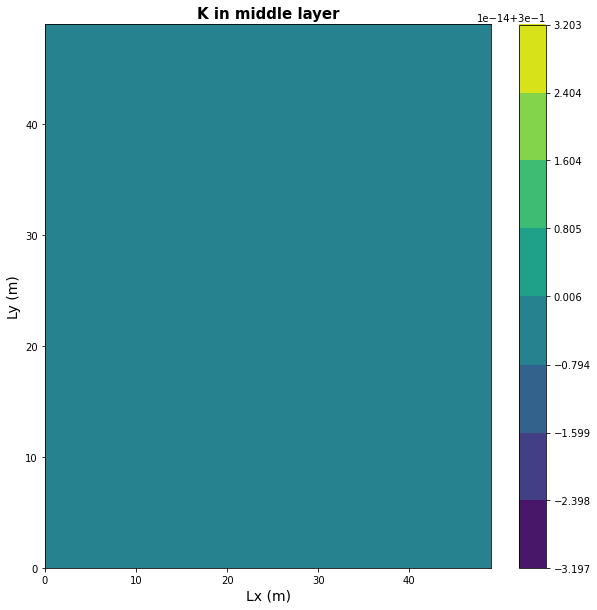

In [8]:
K_vals = np.zeros((nlay,ncol,nrow))
K_vals[:,:,:] = 1             # homoogeneous background hydraulic conductivity 
#K_vals[10:15,10:15,:] = 0.1   # low K inclusion

# assign K vals for each layer
K_vals[0,:,:] = 1 
K_vals[1,:,:] = 0.3 
K_vals[2,:,:] = 1
 

#plot K values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('K in middle layer', fontsize = 15, fontweight = 'bold')
plt.contourf(K_vals[1,:,:])
plt.colorbar()
plt.show()

In [9]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
#bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[:,:,0], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None)

In [10]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper4, steady=steady4)

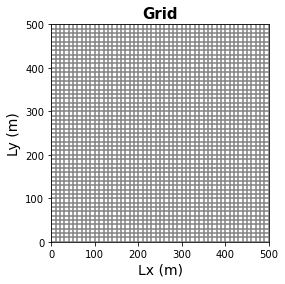

In [11]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

In [12]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     
#ibound2 = np.ones((nlay, nrow, ncol), dtype=np.int32)

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head

In [13]:
#setup initial heads as 70 everywhere, this value will be preserved on constant head boundaries  
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = 50     # set all values to uniform initial condition
H_init[:, :, -1] = 40    #replace last (right) col with desired head value

In [14]:
#Setup alternating pumping values in the bottom layer
well_loc = [2, 20, 20]
Q1 = -250
Q2 = -275

Q_val=np.tile([Q2,Q2],sim_yearsT)
#Q_val=np.append(0,Q_val) # add a period of length 10 at the start for the steady state simulation
                      
Q = {}
for p in range(0,nper4):    #loop over stress periods
    Q[p]=Q_val[p]

well_spd = {}                                                                  # create empty dictionary for well info
for per in range(nper4):                                                        # transient models, iterate over stress periods to assign well stresses
    well_spd[per] = [[well_loc[0], well_loc[1], well_loc[2], Q[per]]]      # assign well coord & pump rate for each stress period


In [15]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=well_spd)  #create object for WEL package

In [16]:
#Recharge 
rech_zone = np.zeros((1,nrow,ncol))               #define an array of zeros of dim (nlay,nrow,ncol) - backgroun ET is zero everywhere
recharge = 1e-4 #m/day                          
#rech_zone[0,8:17,2:17] = recharge
rech_zone[0,:,:] = recharge


rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

In [17]:
'''# ET - this is set up to show how you would add time-varying recharge in a localized area
ET_val1 = 0 #m/day
ET_val2 = 0.01 #m/day
ET_locxy=[[400, 900], [1500, 1600]] #lower left and upper right corners of ET in xy coordinate
extinction_depth = 50

ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
ET_centerpt=(0, int(np.mean(ET_rows)),int(np.mean(ET_cols)))
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET_val2  # assign ET rate to the ET zone

#Setup alternating ET values
ET_val=np.tile([ET_val1, ET_val2],sim_years)
ET_val=np.append(ET_val1,ET_val) # add a period of length 10 at the start for the steady state simulation
                      
ET = {}
for p in range(0,nper):    #loop over stress periods
    ET[p]=ET_zone*ET_val[p]

evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)'''

'# ET - this is set up to show how you would add time-varying recharge in a localized area\nET_val1 = 0 #m/day\nET_val2 = 0.01 #m/day\nET_locxy=[[400, 900], [1500, 1600]] #lower left and upper right corners of ET in xy coordinate\nextinction_depth = 50\n\nET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows\nET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows\nET_centerpt=(0, int(np.mean(ET_rows)),int(np.mean(ET_cols)))\nET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid\nET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET_val2  # assign ET rate to the ET zone\n\n#Setup alternating ET values\nET_val=np.tile([ET_val1, ET_val2],sim_years)\nET_val=np.append(ET_val1,ET_val) # add a period of length 10 at the start for the steady state simulation\n                      \nET = {}\nfor p in range(0,nper):    #loop over

In [18]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

In [19]:

#laytyp = [1,0,1]
laytyp = np.ones((nlay), dtype=np.int32)
#laytyp[0]=1
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_vals, ss=Ss, sy=Sy, storagecoefficient=True, ipakcb=53)

'''lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_vals, 
                                vka=K_vert, ss=Ss,
                                sy=Sy,storagecoefficient=True, ipakcb=53)'''

'lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_vals, \n                                vka=K_vert, ss=Ss,\n                                sy=Sy,storagecoefficient=True, ipakcb=53)'

In [20]:
#create oc stress period data - save for each time step in each stress period. 
oc_spd = {}
for kper in range(nper4):  
    for kstp in range(nstp4[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']

In [21]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

In [22]:
pcg = flopy.modflow.ModflowPcg(model=m)

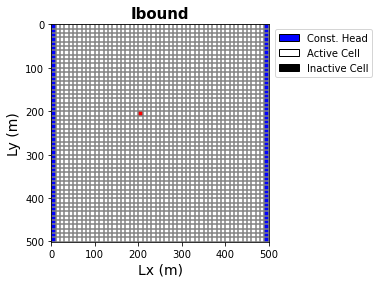

In [23]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=2)
grid = modelmap.plot_grid()
#quadmesh = modelmap.plot_array(rech_zone)
ib = modelmap.plot_ibound()
wel = modelmap.plot_bc("WEL")

#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)



In [24]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder

In [25]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: TestHW8.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/28 22:36:32

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1  

In [26]:
''''budgobj = bf.CellBudgetFile(modelname+'.cbc')
rec_list = budgobj.list_records() 

budgobj2 = bf.CellBudgetFile(modelname2+'.cbc')
rec_list2 = budgobj2.list_records() '''

"'budgobj = bf.CellBudgetFile(modelname+'.cbc')\nrec_list = budgobj.list_records() \n\nbudgobj2 = bf.CellBudgetFile(modelname2+'.cbc')\nrec_list2 = budgobj2.list_records() "

In [27]:
# Read the heads 
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data

'''hds_yr = bf.HeadFile(modelname2+'.hds')                   # reads the binary head file
time_yr = hds_yr.get_times()                              # returns a list of timesteps
head2 = hds_yr.get_data()'''

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object



In [28]:
#get data from python objects
#head2 = []
headarray=np.zeros((len(times),ncol,nrow))
frf=np.zeros((len(times),ncol,nrow))
fff=np.zeros((len(times),ncol,nrow))

temphead = headobj.get_data(totim=nper4) #append heads to head list for each stress per

In [29]:


#rowcounter=-1
for i in times:
    rowcounter+=1
    temphead = headobj.get_data(totim=i) #append heads to head list for each stress per
    headarray[i,:,:] = temphead
    tempfrf = np.squeeze(budgobj.get_data(text='flow right face',totim=i))
    # print(tempfrf)
    frf[:,:,:] = tempfrf
    tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE',totim=i))
    fff[rowcounter,:,:] = tempfff

'''headarray2=np.zeros((len(time_yr),ncol,nrow))
rowcounters=-1
for i in time_yr:
    rowcounters+=1
    temphead2 = headobjs.get_data(totim=i) #append heads to head list for each stress per
    headarray2[rowcounters,:,:] = temphead2'''
    
# extract and plot head time series at specific points
time_series1 = headarray[:,domain_centerpt[1],domain_centerpt[2]]
time_series2 = headarray[well_loc[0],well_loc[1],well_loc[2]]

'''time_series_1 = headarray2[:,domain_centerpt[1],domain_centerpt[2]]
time_series_2 = headarray2[:,well_loc[1],well_loc[2]]
'''

plt.subplot(1,2,1)
plt.title("Head at well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.xticks([0,20,40,60,80,100], ['0', '20', '40','60','80','100'])
plt.plot(elyears, time_series2, 'r-') #plot the time series with points at each record
plt.rcParams["figure.figsize"] = (13,4)
plt.plot(time_series2.mean(), 'bo')

plt.subplot(1, 2, 2)
plt.title("Head at midpoint",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.xticks([0,20,40,60,80,100], ['0', '20', '40','60','80','100'])
plt.plot(elyears, time_series1, 'r-') #plot the time series with points at each record
plt.plot(time_series1.mean(), 'bo')
#plt.tight_layout()

NameError: name 'rowcounter' is not defined

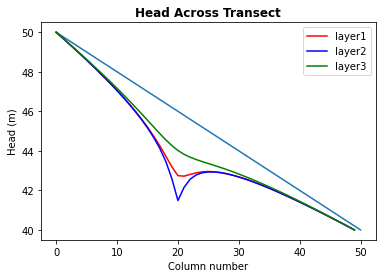

In [30]:
#plot head distribution at years 0, half of sim time, end of sim time
linx = [50,0]
liny = [40,50]
plt.plot(linx,liny)
plt.plot(np.arange(nrow),temphead[0,20,:],'r',label='layer1')
plt.plot(np.arange(nrow),temphead[1,20,:],'b',label='layer2')
plt.plot(np.arange(nrow),temphead[2,25,:],'g',label='layer3')
plt.xlabel('Column number')
plt.ylabel('Head (m)')
plt.title("Head Across Transect",fontweight='bold')
plt.legend()

In [ ]:
# 3d plot

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(temphead[2])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (ft)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title(('3D Heads, Layer '+'3'), fontsize=15, fontweight='bold')
ax.view_init(10,270)
plt.show(surf)

In [ ]:
row = 20
xsec = flopy.plot.PlotCrossSection(model= m, line={"row":row})
# assign key "row" or "column"
#river_plot = xsec.plot_bc(ftype='RIV')
grid_plot = xsec.plot_grid()
patches = xsec.plot_bc('WEL', color='red')
plt.title("Row: " + str(row))

In [31]:
#moddirmp=r"C:\Users\Dalia\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mpath7"
moddirmp=r"C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mpath7"

In [ ]:
'''# MODPATH zones
zone3 = np.ones((nrow, ncol), dtype=np.int32)
zone3[well_loc[1:]] = 2
zones = [1, 1, zone3]

# create particles
# particle group 1
plocs = []
pids = []
for idx in range(nrow):
    plocs.append((0, idx, 2))
    pids.append(idx)
part0 = flopy.modpath.ParticleData(plocs, drape=0, structured=True, particleids=pids)
pg0 = flopy.modpath.ParticleGroup(particlegroupname='PG1', particledata=part0,
                                  filename='ex01a.pg1.sloc')

# particle group 2
v = [(2, 0, 0), (0, 20, 0)]
part1 = flopy.modpath.ParticleData(v, drape=1, structured=True, particleids=[1000, 1001])
pg1 = flopy.modpath.ParticleGroup(particlegroupname='PG2', particledata=part1,
                                  filename='ex01a.pg2.sloc')'''

In [32]:
#Set the range of cell to add particles to 
# [layerstart, rowstart, colstart,  layerend, rowend,  colend]
locsb = [[2, 0, 0, 2, 22, 22]]
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=3, 
                                rowcelldivisions=3, layercelldivisions=1) #Number of part per cell
#setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='test.pg1.sloc')
particlegroups = [pg1]

defaultiface = {'RECHARGE': 6, 'ET': 6}

mpname3=os.path.join(modelname + '_mp')
print(mpname3)
mp3 = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp3, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp3, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  budgetoutputoption='summary',
                                  stoptimeoption='specified', 
                                  particlegroups= particlegroups)


mp3.add_package(rch)
mp3.write_input()
mp3.run_model()
mp3.get_package_list()

TestHW8_mp
FloPy is using the following  executable to run the model: C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    
Processing Time Step     1 Period     2.  Time =  2.00000E+00  Steady-state flow                                                    
Processing Time Step     1 Period     3.  Time =  3.00000E+00  Steady-state flow                                                    
Processing Time Step     1 Period     4.  Time =  4.00000E+00  Steady-state flow                                                    
Processing Time Step     1 Period     5.  Time =  5.00000E+00  Steady-state flow                                                    
Proc

['MPBAS', 'MPSIM', 'RCH']

In [33]:
# obtain heads from model
headobj3 = bf.HeadFile(modelname+'.hds')      #reads the binary head file
times = headobj3.get_times()                   #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])     #returns a numpy array of heads for specified time (last timestep)

In [34]:
#Particle pathlines
fpth = os.path.join(mpname3 + '.mppth')
print(fpth)
pthobj = flopy.utils.PathlineFile('TestHW8_mp.mppth')
#p3 = flopy.utils.PathlineFile(fpth.strip("" "" ))

TestHW8_mp.mppth


In [ ]:
#Particle endpoints
fpth3 = os.path.join(mpname3 + '.mpend')
e3 = flopy.utils.EndpointFile(fpth3, verbose=False)

#make a subset which is all the particles
pall3 = pthobj.get_alldata()  
eall3 = e3.get_alldata()
        
#make a subset which is particles ending in the well
nodewell3 = m.dis.get_node([(2,well_loc[1], well_loc[2])])
print(nodewell3)
pwell3 = pthobj.get_destination_pathline_data(dest_cells=nodewell3)
ewell3 = e3.get_destination_endpoint_data(dest_cells=nodewell3)

In [ ]:
#f, axes = plt.plot(figsize=(10, 5))

'''ax = axes[0]
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(1, 1, 1)

ax.set_aspect('equal')
ax.set_title('1 Layer Scenario Flowlines')
mm = flopy.plot.PlotMapView(model=m1, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall1, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by well') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell1, layer='all', color='orange', lw=0.5, linestyle=':', label='captured') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.ax.legend();'''
mm = flopy.plot.PlotMapView(model=m)
#ax = axes
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(1, 1, 1)


#mm.plot.title('3 Layer Scenario Flowlines')
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall3, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by well') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell3, layer='all', color='orange', lw=0.5, linestyle=':', label='captured') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.ax.legend();
mm.plot_endpoint(ewell3, direction='starting', colorbar=True)
mm.plot_pathline(ewell3, layer='all', color='orange', lw=0.5, linestyle=':', label='3 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
plt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])
#plt.tight_layout();
#plt.savefig('Pathlines.png')